# FFT

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2017 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate

### Empirical order of growth

Sometimes we can figure out what order of growth a function belongs to by running it with a range of problem sizes and measuring the run time.

`order.py` contains functions from Appendix A we can use to estimate order of growth.

In [2]:
from order import run_timing_test, plot_timing_test

### DFT

Here's an implementation of DFT using outer product to construct the transform matrix, and dot product to compute the DFT.

In [3]:
PI2 = 2 * np.pi

def dft(xs):
    N = len(xs)
    ns = np.arange(N) / N
    ks = np.arange(N)
    args = np.outer(ks, ns)
    M = np.exp(-1j * PI2 * args)
    amps = M.dot(xs)
    return amps

Here's an example comparing this implementation of DFT with `np.fft.fft`

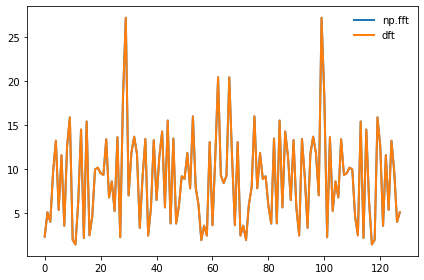

In [4]:
xs = np.random.normal(size=128)
spectrum1 = np.fft.fft(xs)
plt.plot(np.abs(spectrum1), label='np.fft')

spectrum2 = dft(xs)
plt.plot(np.abs(spectrum2), label='dft')

np.allclose(spectrum1, spectrum2)
decorate()

Now, let's see what the asymptotic behavior of `np.fft.fft` looks like:

1024 0.0
2048 0.0
4096 0.015625
8192 0.0
16384 0.0
32768 0.0
65536 0.015625
131072 0.0
262144 0.0625
524288 0.09375
1048576 0.203125
2097152 0.40625
4194304 0.765625
8388608 1.625


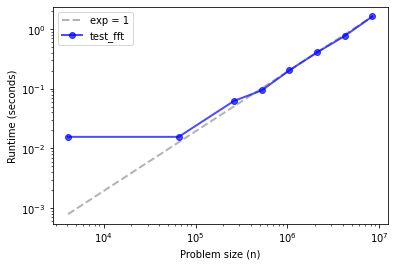

In [5]:
def test_fft(n):
    xs = np.random.normal(size=n)
    spectrum = np.fft.fft(xs)

ns, ts = run_timing_test(test_fft)
plot_timing_test(ns, ts, 'test_fft', exp=1)

Up through the biggest array I can handle on my computer, it's hard to distinguish from linear.

And let's see what my implementation of DFT looks like: 

1024 0.171875
2048 0.4375
4096 1.875


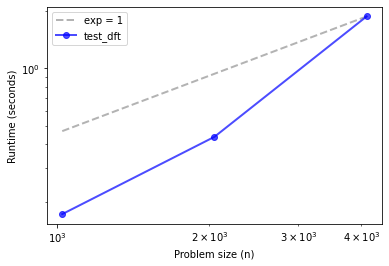

In [6]:
def test_dft(n):
    xs = np.random.normal(size=n)
    spectrum = dft(xs)

ns, ts = run_timing_test(test_dft)
plot_timing_test(ns, ts, 'test_dft', exp=1)

Definitely not linear.  How about quadratic?

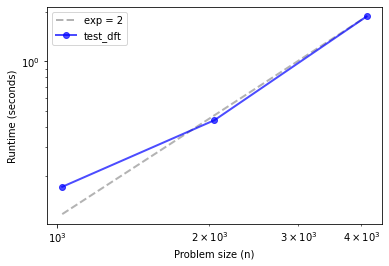

In [7]:
plot_timing_test(ns, ts, 'test_dft', exp=2)

Looks quadratic.

### Implementing FFT

Ok, let's try our own implementation of FFT.

First I'll get the divide and conquer part of the algorithm working:

In [8]:
def fft_norec(ys):
    N = len(ys)
    He = dft(ys[::2])
    Ho = dft(ys[1::2])
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

This version breaks the array in half, uses `dft` to compute the DFTs of the halves, and then uses the D-L lemma to stich the results back up.

Let's see what the performance looks like.

1024 0.125
2048 0.234375
4096 0.9375
8192 3.765625


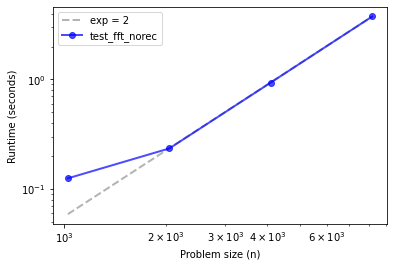

In [9]:
def test_fft_norec(n):
    xs = np.random.normal(size=n)
    spectrum = fft_norec(xs)

ns, ts = run_timing_test(test_fft_norec)
plot_timing_test(ns, ts, 'test_fft_norec', exp=2)

Looks about the same as DFT, quadratic.

**Exercise:**  Starting with fft_norec, write a function called fft_rec that's fully recursive; that is, instead of using `dft` to compute the DFTs of the halves, it should use `fft_rec`.  Of course, you will need a base case to avoid an infinite recursion.  You have two options:

1) The DFT of an array with length 1 is the array itself.

2) If the parameter, `ys`, is smaller than some threshold length, you could use DFT.

Use `test_fft_rec`, below, to check the performance of your function.

In [10]:
# Solution

def fft_rec(ys):
    N = len(ys)
    if N == 1:
        return ys
    
    He = fft_rec(ys[::2])
    Ho = fft_rec(ys[1::2])
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

In [11]:
xs = np.random.normal(size=128)
spectrum1 = np.fft.fft(xs)

spectrum2 = fft_rec(xs)

np.allclose(spectrum1, spectrum2)

True

1024 0.03125
2048 0.125
4096 0.15625
8192 0.265625
16384 0.4375
32768 0.828125
65536 2.015625


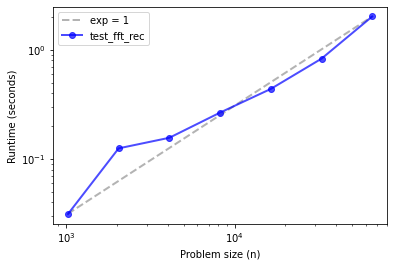

In [12]:
def test_fft_rec(n):
    xs = np.random.normal(size=n)
    spectrum = fft_rec(xs)

ns, ts = run_timing_test(test_fft_rec)
plot_timing_test(ns, ts, 'test_fft_rec', exp=1)

If things go according to plan, your FFT implementation should be faster than `dft` and `fft_norec`, but probably not as fast as `np.fft.fft`.  And it might be a bit steeper than linear.